# A Quantum-Enhanced LSTM Layer

One field that so far has been poorly explored in Quantum Machine Learning is Natural Language Processing (NLP), the sub-field of Artificial Intelligence that gives computers the ability to read, write and to some extent comprehend written text. 

As documents are usually presented as sequences of words, historically one of the most successful techniques to manipulate this kind of data has been the Recurrent Neural Network architecture, and in particular a variant called Long Short-Term Memory (LSTM). LSTMs allowed machines to perform translations, classification and intent detection with state-of-the-art accuracy until the advent of Transformer networks. Still, it’s interesting at least from an educational point of view to dig into LSTMs to see what good quantum computing may bring to the field. For a more thorough discussion, please refer to “Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783) and “Recurrent Quantum Neural Networks” by J. Bausch (arXiv:2006.14619).

In [1]:
!pip install -r requirements.txt

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qlstm_pennylane import QLSTM

Here we define the possible tags: determinant, noun, verb.

In [6]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [7]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Now we can prepare the input dataset.

In [8]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [9]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [10]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [11]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [16]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [17]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 1.145 Acc = 0.33
Epoch 2 / 300: Loss = 1.135 Acc = 0.33
Epoch 3 / 300: Loss = 1.126 Acc = 0.33
Epoch 4 / 300: Loss = 1.119 Acc = 0.22
Epoch 5 / 300: Loss = 1.112 Acc = 0.22
Epoch 6 / 300: Loss = 1.106 Acc = 0.33
Epoch 7 / 300: Loss = 1.100 Acc = 0.22
Epoch 8 / 300: Loss = 1.095 Acc = 0.22
Epoch 9 / 300: Loss = 1.090 Acc = 0.33
Epoch 10 / 300: Loss = 1.086 Acc = 0.33
Epoch 11 / 300: Loss = 1.082 Acc = 0.44
Epoch 12 / 300: Loss = 1.079 Acc = 0.44
Epoch 13 / 300: Loss = 1.075 Acc = 0.44
Epoch 14 / 300: Loss = 1.072 Acc = 0.44
Epoch 15 / 300: Loss = 1.069 Acc = 0.44
Epoch 16 / 300: Loss = 1.066 Acc = 0.44
Epoch 17 / 300: Loss = 1.063 Acc = 0.44
Epoch 18 / 300: Loss = 1.061 Acc = 0.44
Epoch 19 / 300: Loss = 1.058 Acc = 0.44
Epoch 20 / 300: Loss = 1.056 Acc = 0.44
Epoch 21 / 300: Loss = 1.053 Acc = 0.44
Epoch 22 / 300: Loss = 1.051 Acc = 0.44
Epoch 23 / 300: Loss = 1.049 Acc = 0.44
Epoch 24 / 300: Loss = 1.047 Acc = 0.44
Epoch 25 / 300: Loss = 1.044 Acc = 0.44
Epoch 26 

Epoch 205 / 300: Loss = 0.139 Acc = 1.00
Epoch 206 / 300: Loss = 0.138 Acc = 1.00
Epoch 207 / 300: Loss = 0.136 Acc = 1.00
Epoch 208 / 300: Loss = 0.134 Acc = 1.00
Epoch 209 / 300: Loss = 0.132 Acc = 1.00
Epoch 210 / 300: Loss = 0.130 Acc = 1.00
Epoch 211 / 300: Loss = 0.129 Acc = 1.00
Epoch 212 / 300: Loss = 0.127 Acc = 1.00
Epoch 213 / 300: Loss = 0.125 Acc = 1.00
Epoch 214 / 300: Loss = 0.124 Acc = 1.00
Epoch 215 / 300: Loss = 0.122 Acc = 1.00
Epoch 216 / 300: Loss = 0.121 Acc = 1.00
Epoch 217 / 300: Loss = 0.119 Acc = 1.00
Epoch 218 / 300: Loss = 0.118 Acc = 1.00
Epoch 219 / 300: Loss = 0.116 Acc = 1.00
Epoch 220 / 300: Loss = 0.115 Acc = 1.00
Epoch 221 / 300: Loss = 0.113 Acc = 1.00
Epoch 222 / 300: Loss = 0.112 Acc = 1.00
Epoch 223 / 300: Loss = 0.111 Acc = 1.00
Epoch 224 / 300: Loss = 0.109 Acc = 1.00
Epoch 225 / 300: Loss = 0.108 Acc = 1.00
Epoch 226 / 300: Loss = 0.107 Acc = 1.00
Epoch 227 / 300: Loss = 0.106 Acc = 1.00
Epoch 228 / 300: Loss = 0.104 Acc = 1.00
Epoch 229 / 300:

In [18]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [19]:
print_result(model_classical)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [20]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [21]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 1.086 Acc = 0.33
Epoch 2 / 300: Loss = 1.081 Acc = 0.33
Epoch 3 / 300: Loss = 1.077 Acc = 0.33
Epoch 4 / 300: Loss = 1.073 Acc = 0.33
Epoch 5 / 300: Loss = 1.070 Acc = 0.33
Epoch 6 / 300: Loss = 1.067 Acc = 0.33
Epoch 7 / 300: Loss = 1.065 Acc = 0.44
Epoch 8 / 300: Loss = 1.062 Acc = 0.44
Epoch 9 / 300: Loss = 1.060 Acc = 0.44
Epoch 10 / 300: Loss = 1.058 Acc = 0.44
Epoch 11 / 300: Loss = 1.056 Acc = 0.44
Epoch 12 / 300: Loss = 1.055 Acc = 0.44
Epoch 13 / 300: Loss = 1.053 Acc = 0.44
Epoch 14 / 300: Loss = 1.051 Acc = 0.44
Epoch 15 / 300: Loss = 1.049 Acc = 0.44
Epoch 16 / 300: Loss = 1.048 Acc = 0.44
Epoch 17 / 300: Loss = 1.046 Acc = 0.44
Epoch 18 / 300: Loss = 1.044 Acc = 0.44
Epoch 19 / 300: Loss = 1.042 Acc = 0.44
Epoch 20 / 300: Loss = 1.040 Acc = 0.44
Epoch 21 / 300: Loss = 1.037 Acc = 0.44
Epoch 22 / 300: Loss = 1.035 Acc = 0.44
Epoch 23 / 300: Loss = 1.032 Acc = 0.44
Epoch 24 / 300: Loss = 1.030 Acc = 0.44
Epoch 25 / 300: Loss = 1.027 Acc = 0.44
Epoch 26 

Epoch 204 / 300: Loss = 0.145 Acc = 1.00
Epoch 205 / 300: Loss = 0.143 Acc = 1.00
Epoch 206 / 300: Loss = 0.141 Acc = 1.00
Epoch 207 / 300: Loss = 0.139 Acc = 1.00
Epoch 208 / 300: Loss = 0.137 Acc = 1.00
Epoch 209 / 300: Loss = 0.135 Acc = 1.00
Epoch 210 / 300: Loss = 0.133 Acc = 1.00
Epoch 211 / 300: Loss = 0.131 Acc = 1.00
Epoch 212 / 300: Loss = 0.129 Acc = 1.00
Epoch 213 / 300: Loss = 0.128 Acc = 1.00
Epoch 214 / 300: Loss = 0.126 Acc = 1.00
Epoch 215 / 300: Loss = 0.124 Acc = 1.00
Epoch 216 / 300: Loss = 0.123 Acc = 1.00
Epoch 217 / 300: Loss = 0.121 Acc = 1.00
Epoch 218 / 300: Loss = 0.120 Acc = 1.00
Epoch 219 / 300: Loss = 0.118 Acc = 1.00
Epoch 220 / 300: Loss = 0.117 Acc = 1.00
Epoch 221 / 300: Loss = 0.115 Acc = 1.00
Epoch 222 / 300: Loss = 0.114 Acc = 1.00
Epoch 223 / 300: Loss = 0.113 Acc = 1.00
Epoch 224 / 300: Loss = 0.111 Acc = 1.00
Epoch 225 / 300: Loss = 0.110 Acc = 1.00
Epoch 226 / 300: Loss = 0.109 Acc = 1.00
Epoch 227 / 300: Loss = 0.107 Acc = 1.00
Epoch 228 / 300:

In [23]:
print_result(model_quantum)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


### Plot the training history

In [37]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM Loss", color='tab:blue', linestyle='solid')
    ax1.plot(loss_q, label="Quantum LSTM Loss", color='tab:red', linestyle='dashed')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM Accuracy", color='tab:blue', linestyle='solid')
    ax2.plot(acc_q, label="Quantum LSTM Accuracy", color='tab:red', linestyle='dashed')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.5)
    plt.legend(loc="upper right")

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

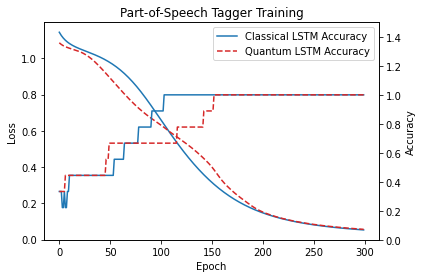

In [38]:
plot_history(history_classical, history_quantum)

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence. Due to the complexity of the simulation of the quantum circuit, it took approximatively 15 minutes to finish the training, to be compared to a mere 8 seconds for the classical case. 